In [141]:
def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

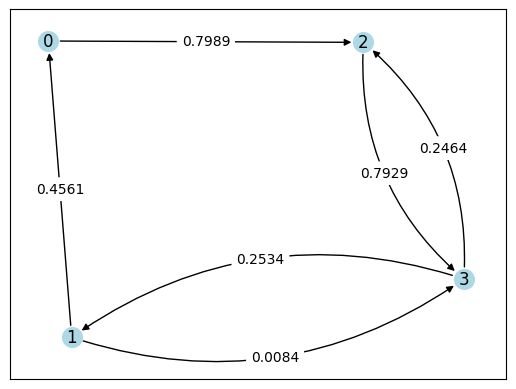

In [142]:

import networkx as nx
import torch
import torch_geometric
import matplotlib.pyplot as plt

# Generate a random graph
G = nx.gnp_random_graph(4, 0.5, directed=True)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Assign random weights to the edges
for u, v in G.edges():
    G[u][v]['weight'] = round(torch.rand(1).item(), 4)

# Convert the graph to pytorch_geometric format
data = torch_geometric.utils.from_networkx(G)

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
nx.draw_networkx_labels(G, pos)

curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
straight_edges = list(set(G.edges()) - set(curved_edges))
nx.draw_networkx_edges(G, pos, edgelist=straight_edges)
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')

edge_weights = nx.get_edge_attributes(G,'weight')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
my_draw_networkx_edge_labels(G, pos, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad)
nx.draw_networkx_edge_labels(G, pos, edge_labels=straight_edge_labels,rotate=False)


# nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=2, edge_cmap=plt.cm.Blues)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_color='red')
plt.show()



In [192]:
data.edge_index, data.weight

(tensor([[0, 1, 1, 2, 3, 3],
         [2, 0, 3, 3, 1, 2]]),
 tensor([0.7989, 0.4561, 0.0084, 0.7929, 0.2534, 0.2464]))

In [193]:
# Construct adjacency matrix
adj = torch.zeros((data.num_nodes, data.num_nodes))
adj[data.edge_index[1], data.edge_index[0]] = data.weight
print(adj)

tensor([[0.0000, 0.4561, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2534],
        [0.7989, 0.0000, 0.0000, 0.2464],
        [0.0000, 0.0084, 0.7929, 0.0000]])


In [194]:
target_node = 3

In [195]:
print(f"Edge (2, 3): {0.7929 + 0.7929 * 0.2534 * 0.0084 + 0.7929 * 0.2464 * 0.7929:.4f}")
print(f"Edge (3, 2): {0.2464 * 0.7929:.4f}")
print(f"Edge (3, 1): {0.2534 * 0.0084:.4f}")
print(f"Edge (0, 2): {0.7989 * 0.7929:.4f}")
print(f"Edge (1, 0): {0.4561 * 0.7989 * 0.7929:.4f}")

Edge (2, 3): 0.9495
Edge (3, 2): 0.1954
Edge (3, 1): 0.0021
Edge (0, 2): 0.6334
Edge (1, 0): 0.2889


In [196]:
adj2 = adj @ adj
print(adj2)

tensor([[0.0000, 0.0000, 0.0000, 0.1156],
        [0.0000, 0.0021, 0.2009, 0.0000],
        [0.0000, 0.3664, 0.1954, 0.0000],
        [0.6334, 0.0000, 0.0000, 0.1975]])


In [197]:
select_matrix = torch.zeros_like(adj)
select_matrix[target_node, :] = 1

In [200]:
result = adj2[target_node, :].expand_as(adj).t() * adj +\
    adj[target_node, :].expand_as(adj).t() * adj +\
    select_matrix * adj

In [202]:
print(f"Edge (2, 3): {result[3, 2]:.4f}")
print(f"Edge (3, 2): {result[2, 3]:.4f}")
print(f"Edge (3, 1): {result[1, 3]:.4f}")
print(f"Edge (0, 2): {result[2, 0]:.4f}")
print(f"Edge (1, 0): {result[0, 1]:.4f}")

Edge (2, 3): 0.9495
Edge (3, 2): 0.1954
Edge (3, 1): 0.0021
Edge (0, 2): 0.6334
Edge (1, 0): 0.2889
